In [1]:
pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 3.4 MB/s eta 0:00:00


In [8]:
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wd_yzn_v
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wd_yzn_v
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=365a2f9194c0d16e63f1483d44388a80ea5c0094e8d3633fc82c8dab8643440a
  Stored in directory: /tmp/pip-ephem-wheel-cache-dh7cn9ht/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-05-08 14:45:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.78, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226

In [4]:
#Imporing required libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import torch
import torchvision
import sys

In [5]:
#Loading the image
image = cv2.imread('sam8.png')
images = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

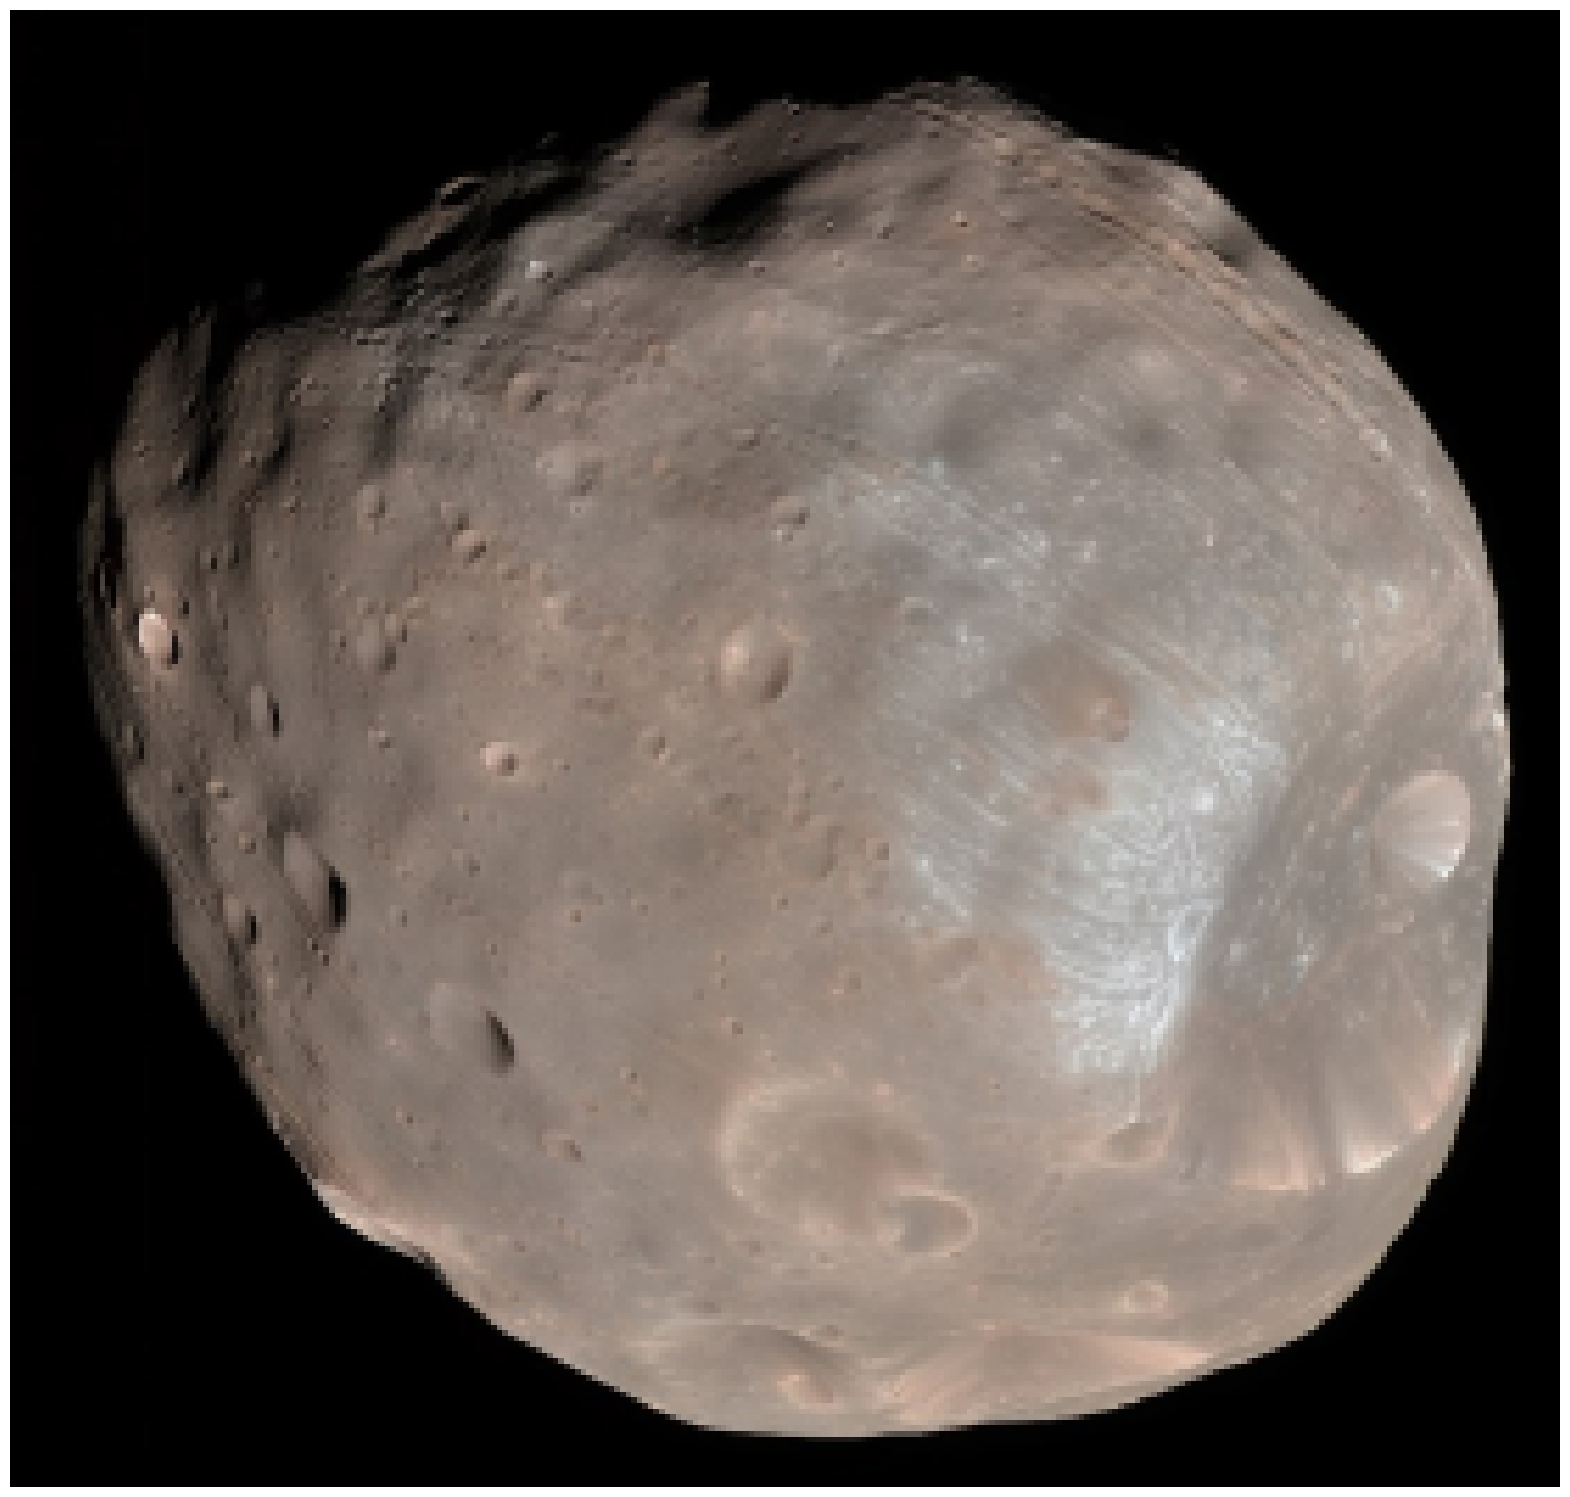

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(images)
plt.axis('off')
plt.show()

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [10]:
#Loading the SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
#Mask generation
sam_result = mask_generator.generate(images)

In [12]:
#Sorting the masks according to the area of the mask
sam_result=sorted(sam_result, key=lambda x: x['area'], reverse=True)

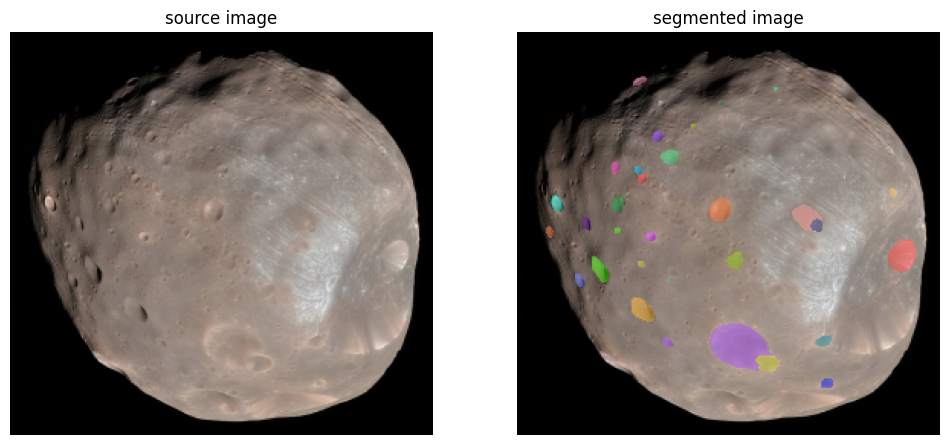

In [13]:
#Showing Original and Segmented image
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result[1:]) #removing the main background mask

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [14]:
print(len(sam_result))
print(sam_result[0].keys())

33
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


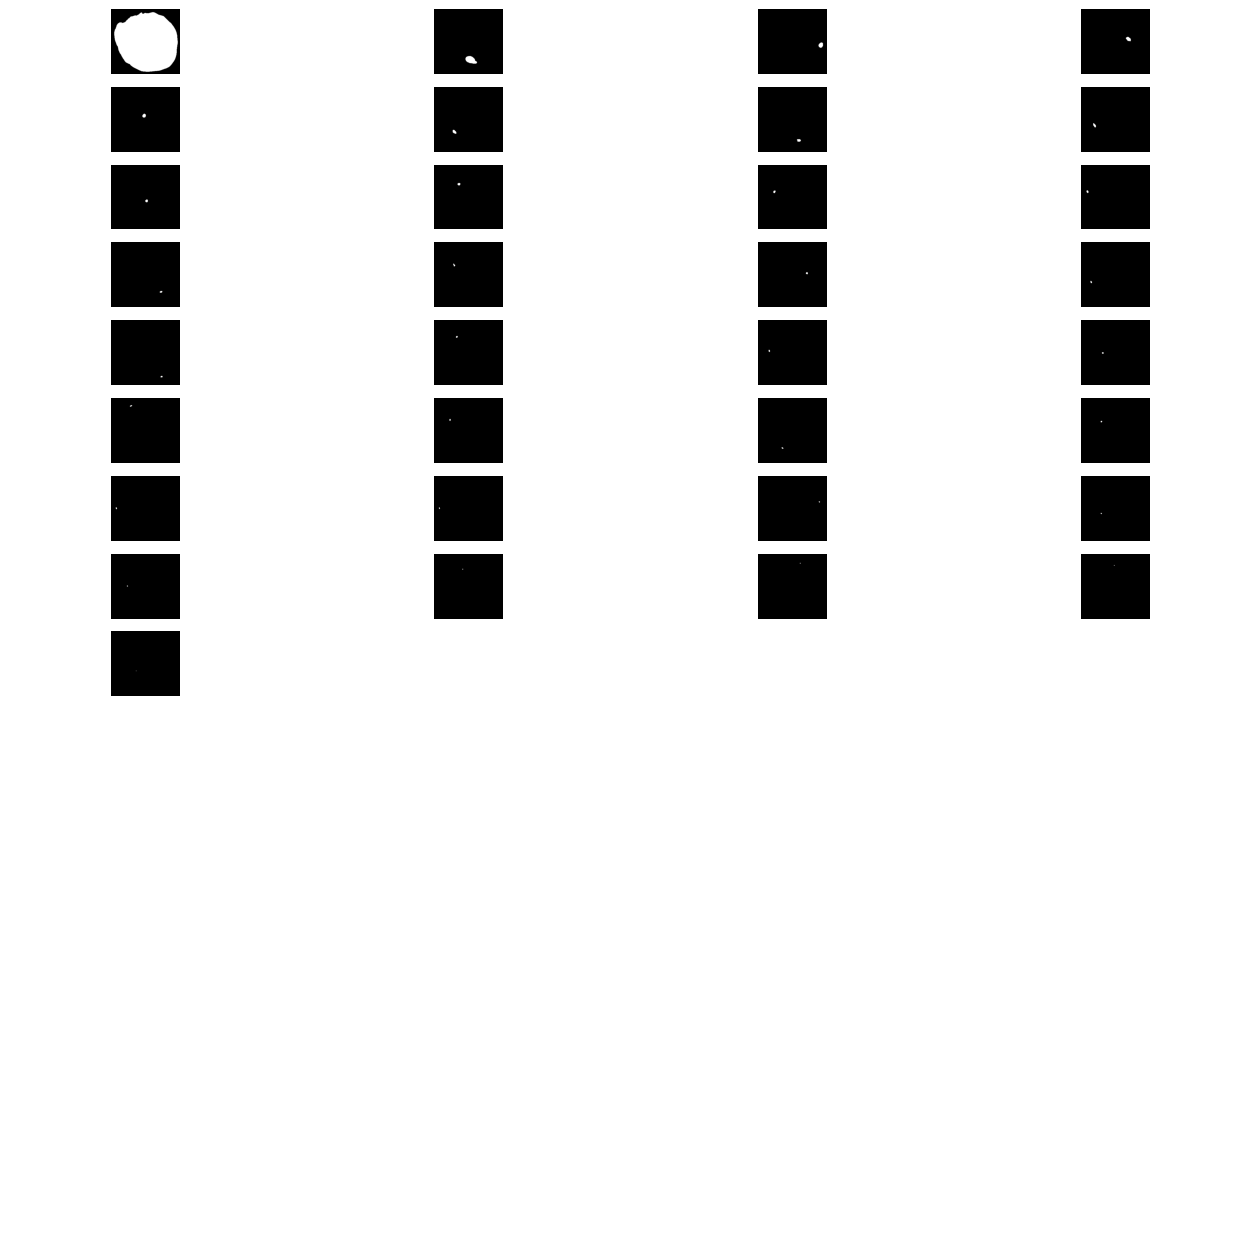

In [16]:
#All masks are appended into a list
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(16, int(len(masks) / 8)),
    size=(16, 16)
)

In [17]:
# Calculate circularity parameters
def calculate_circularity(mask):
    A = np.sum(mask)
    r = np.sqrt(A / np.pi)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        P = cv2.arcLength(contours[0], closed=True)
        d = 2 * r * np.pi
        n = (d / P) if P != 0 else 0
        return n
    else:
        return 0

In [18]:
# Fitting ellipse to the mask
def calculate_ellipticity(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours and len(contours[0]) >= 5:
        ellipse = cv2.fitEllipse(contours[0])
        a = ellipse[1][0] / 2
        b = ellipse[1][1] / 2
        q = (np.pi * a * b) / np.sum(mask)
        return q
    else:
        return None

In [19]:
#Filter masks which are not circular and elliptical
def filter_masks_by_shape(masks, n_threshold=0.9, q_threshold=0.7, m_threshold=0.6):
    filtered_masks = []

    for mask in masks:
        n = calculate_circularity(mask)
        q = calculate_ellipticity(mask)

        if n is not None and q is not None:
            m = q
            if (abs(n - 1) <= n_threshold) and (abs(m - 1) <= m_threshold):
                filtered_masks.append(mask)

    return filtered_masks

In [20]:
#Draw circles and ellipse ouver the filtered masks
def fit_shape_to_edges(image, mask):
    mask_array = np.array(mask)
    # Apply Canny edge detection to the mask
    edges = cv2.Canny(mask_array.astype(np.uint8) * 255, 100, 200)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours and len(contours[0]) >= 5:
        contour = contours[0]
        if len(contour) == 5:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(image, center, radius, (0, 0, 255), 2)
            return ('circle', (center, radius))
        else:
            ellipse = cv2.fitEllipse(contour)
            cv2.ellipse(image, ellipse, (0, 0, 255), 2)
            return ('ellipse', ellipse)

    return None

In [24]:
def process_image(image, masks):
    result_image = image.copy()

    # Filter masks by shape
    filtered_masks = filter_masks_by_shape(masks)

    # Draw filtered masks on the result image
    mask_overlay = np.zeros_like(result_image)
    for filtered_mask in filtered_masks:
        mask_overlay[filtered_mask] = (0, 255, 0)
    cv2.imwrite('filtered_masks.jpg', cv2.addWeighted(result_image, 1, mask_overlay, 0.5, 0)) #saving the filtered mask image

    # Draw shapes on the filtered mask image
    shapes_image = result_image.copy()
    shapes_info = []
    for filtered_mask in filtered_masks:
        shape_info = fit_shape_to_edges(shapes_image, filtered_mask)
        if shape_info:
            shapes_info.append(shape_info)

    # Display the image with detected shapes
    for shape_type, shape_data in shapes_info:
        if shape_type == 'circle':
            center, radius = shape_data
            cv2.circle(shapes_image, center, radius, (0, 0, 255), 2)
        elif shape_type == 'ellipse':
            cv2.ellipse(shapes_image, shape_data, (0, 0, 255), 2)
    cv2.imwrite('shapes_on_filtered_mask.jpg', shapes_image) #saving the sketched image
    return filtered_masks

# Process the image with the specified mask
filtered_masks=process_image(images, masks[1:])


In [23]:
#No.of masks before filtering
len(masks)

33

In [25]:
#No.of masks after filtering
len(filtered_masks)

30